In [551]:
from scipy.stats import spearmanr
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from scipy.stats import chi2_contingency
from scipy.stats.mstats import winsorize
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from IPython.core.interactiveshell import InteractiveShell
from statsmodels.stats.outliers_influence import variance_inflation_factor

import os
import warnings
import pandas as pd
import seaborn as sns

In [552]:
plt.rc('font', family='GULIM')
warnings.filterwarnings(action='ignore')
InteractiveShell.ast_node_interactivity = "all"

In [553]:
input_dir = '../Database/'
file_train = 'train.csv'
file_test = 'test.csv'
train = pd.read_csv(os.path.join(input_dir, file_train))
test = pd.read_csv(os.path.join(input_dir, file_test))

In [554]:
# train

In [555]:
label_encoder = LabelEncoder()
encoder_data = label_encoder.fit_transform(list(train['대출기간']))
train['대출기간'] = pd.DataFrame(encoder_data)

encoder_data = label_encoder.transform(list(test['대출기간']))
test['대출기간'] = pd.DataFrame(encoder_data)

In [556]:
train['근로기간'] = train['근로기간'].str.extract(r'(\d+)')
train['근로기간'] = train['근로기간'].fillna(0)
train['근로기간'] = train['근로기간'].astype(int)

test['근로기간'] = test['근로기간'].str.extract(r'(\d+)')
test['근로기간'] = test['근로기간'].fillna(0)
test['근로기간'] = test['근로기간'].astype(int)

In [557]:
label_encoder = LabelEncoder()
encoder_data = label_encoder.fit_transform(list(train['주택소유상태']))
train['주택소유상태'] = pd.DataFrame(encoder_data)

encoder_data = label_encoder.transform(list(test['주택소유상태']))
test['주택소유상태'] = pd.DataFrame(encoder_data)

In [558]:
test.loc[34486, '대출목적'] = '기타'

In [559]:
label_encoder = LabelEncoder()
encoder_data = label_encoder.fit_transform(list(train['대출목적']))
train['대출목적'] = pd.DataFrame(encoder_data)

encoder_data = label_encoder.transform(list(test['대출목적']))
test['대출목적'] = pd.DataFrame(encoder_data)

In [560]:
label_encoder = LabelEncoder()
encoder_data = label_encoder.fit_transform(list(train['대출등급']))
train['대출등급'] = pd.DataFrame(encoder_data)

In [561]:
train.set_index(train['ID'], inplace=True)
train.drop(columns='ID', inplace=True)

test.set_index(test['ID'], inplace=True)
test.drop(columns='ID', inplace=True)

In [520]:
def do_pca(X_pca):
    columns_pca = [f'PCA_{i}' for i in range(1, X_pca.shape[1] + 1)]
    X_pca_df = pd.DataFrame(X_pca, columns=columns_pca)
    return X_pca_df

In [521]:
# scaler = StandardScaler()
# scaler = MinMaxScaler()
scaler = RobustScaler()
pca = PCA(n_components=0.99)

gt = pd.DataFrame(train['대출등급'], columns=['대출등급'])
to_normalize_list = ['대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수', '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수']
X = pd.DataFrame(train[to_normalize_list], columns=to_normalize_list, index=train.index)
Y = pd.DataFrame(test[to_normalize_list], columns=to_normalize_list, index=test.index)

data_scaled = scaler.fit_transform(X)
# X_pca = pca.fit_transform(data_scaled)
# data_scaled = do_pca(X_pca)
# data_scaled.index = train.index

data_scaled = pd.DataFrame(data_scaled, columns=to_normalize_list, index=train.index)

train.drop(columns=to_normalize_list, inplace=True)
train.drop(columns='대출등급', inplace=True)
train = pd.concat([gt, data_scaled, train], axis=1)

data_scaled = scaler.transform(Y)
# X_pca = pca.transform(data_scaled)
# data_scaled = do_pca(X_pca)
# data_scaled.index = test.index

data_scaled = pd.DataFrame(data_scaled, columns=to_normalize_list, index=test.index)

test.drop(columns=to_normalize_list, inplace=True)
test = pd.concat([data_scaled, test], axis=1)
# print(pca.explained_variance_ratio_)

In [118]:
gt = pd.DataFrame(train['대출등급'], columns=['대출등급'])
to_normalize_list = ['대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수', '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수']

X = pd.DataFrame(train[to_normalize_list], columns=to_normalize_list, index=train.index)
Y = pd.DataFrame(test[to_normalize_list], columns=to_normalize_list, index=test.index)

train.drop(columns=to_normalize_list, inplace=True)
train.drop(columns='대출등급', inplace=True)
test.drop(columns=to_normalize_list, inplace=True)

train = pd.concat([gt, X, train], axis=1)
test = pd.concat([Y, test], axis=1)

<Axes: >

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(1, 0, '대출금액'),
  Text(2, 0, '대출기간'),
  Text(3, 0, '근로기간'),
  Text(4, 0, '주택소유상태'),
  Text(5, 0, '연간소득'),
  Text(6, 0, '부채_대비_소득_비율'),
  Text(7, 0, '총계좌수'),
  Text(8, 0, '대출목적'),
  Text(9, 0, '최근_2년간_연체_횟수'),
  Text(10, 0, '총상환원금'),
  Text(11, 0, '총상환이자'),
  Text(12, 0, '총연체금액'),
  Text(13, 0, '연체계좌수'),
  Text(14, 0, '대출등급')])

Text(0.5, 0.98, 'Train Data')

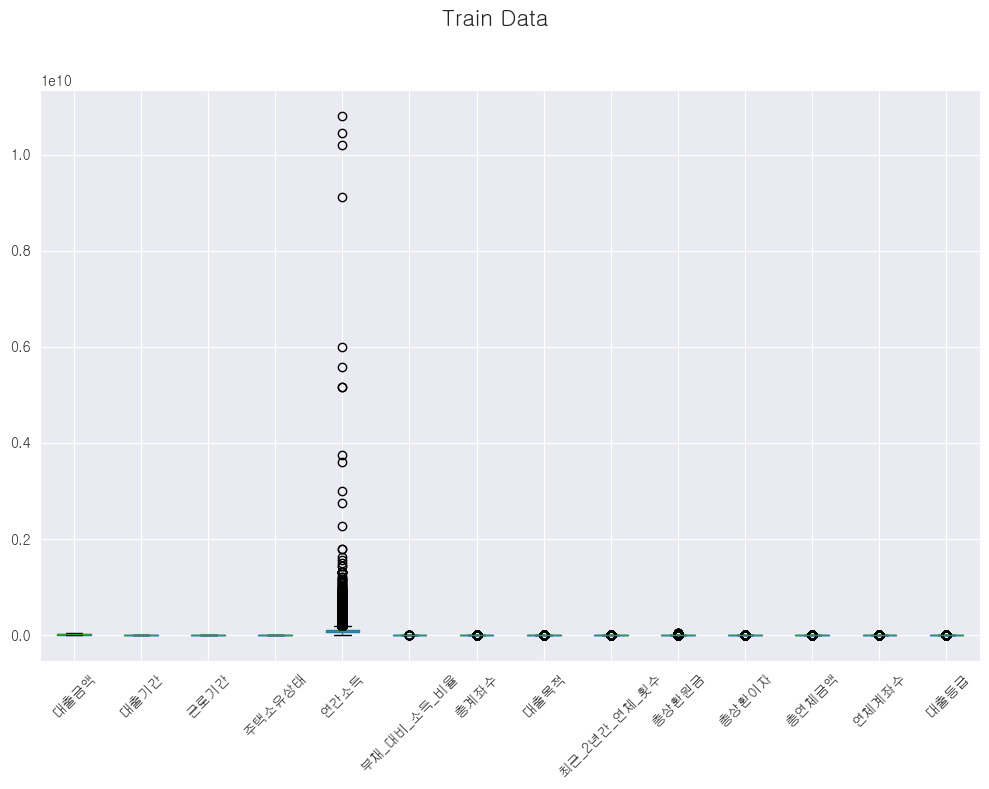

In [548]:
fig, ax = plt.subplots(figsize=(10, 8))
train.boxplot(ax=ax)
plt.xticks(rotation=45)
fig.suptitle('Train Data', fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.96])
fig.show()

In [313]:
def count_outlier(train):
    Q1 = train.quantile(0.25)
    Q3 = train.quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = train[(train < lower_bound) | (train > upper_bound)]
    number_of_outliers = outliers.count()
    
    print(number_of_outliers)

In [549]:
columns = ['대출금액', '연간소득', '부채_대비_소득_비율', '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총계좌수', '총연체금액', '연체계좌수']
count_outlier(train['총상환원금'])
for col in columns:
    train[col] = winsorize(train[col], limits=[0.00005, 0.00005])
    
count_outlier(train['총상환원금'])

5196
5196


<Axes: >

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(1, 0, '대출금액'),
  Text(2, 0, '대출기간'),
  Text(3, 0, '근로기간'),
  Text(4, 0, '주택소유상태'),
  Text(5, 0, '연간소득'),
  Text(6, 0, '부채_대비_소득_비율'),
  Text(7, 0, '총계좌수'),
  Text(8, 0, '대출목적'),
  Text(9, 0, '최근_2년간_연체_횟수'),
  Text(10, 0, '총상환원금'),
  Text(11, 0, '총상환이자'),
  Text(12, 0, '총연체금액'),
  Text(13, 0, '연체계좌수'),
  Text(14, 0, '대출등급')])

Text(0.5, 0.98, 'Train Data')

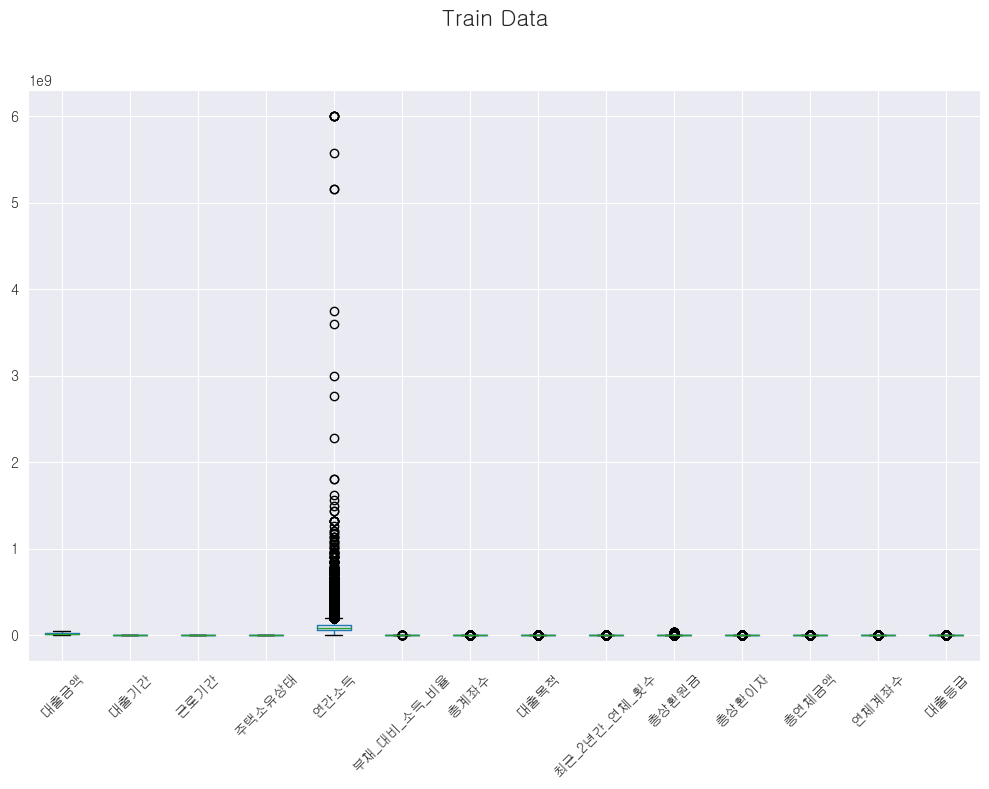

In [550]:
fig, ax = plt.subplots(figsize=(10, 8))
train.boxplot(ax=ax)
plt.xticks(rotation=45)
fig.suptitle('Train Data', fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.96])
fig.show()

([<matplotlib.patches.Wedge at 0x1143cd8b9d0>,
 [Text(-1.0679405846819419, -0.26363404102883226, '1'),
  Text(0.5394722331155161, -0.9586290782661241, '2'),
  Text(1.0173275069415357, 0.41838348870398734, '0'),
  Text(0.2161230797178815, 1.0785596016972165, '3'),
  Text(-0.505845100747086, 0.9767910390918677, '4'),
  Text(-0.7747874672170625, 0.7808356937559716, '5'),
  Text(-0.8328814037911351, 0.718546148287574, '6')])

(-1.099998520897369,
 1.099998036821854,
 -1.0999998444812455,
 1.0999991351940324)

Text(0.5, 1.0, 'Class Distribution')

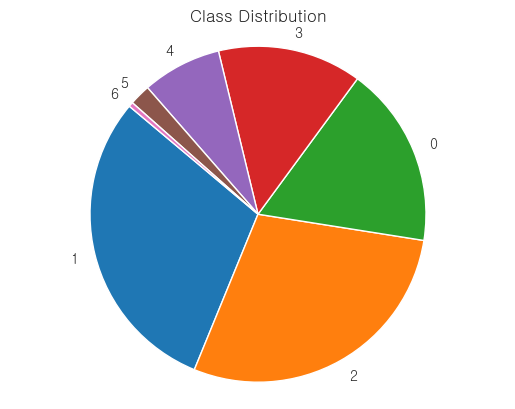

In [59]:
X = train.drop(columns=['대출등급'])
y = train['대출등급']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

class_counts = y.value_counts()

plt.pie(class_counts, labels=class_counts.index, startangle=140)
plt.axis('equal')
plt.title('Class Distribution')
plt.show()

([<matplotlib.patches.Wedge at 0x1141a9cff10>,
 [Text(-1.065985020297715, 0.27143311607259774, '0'),
  Text(-0.8768457179688377, -0.6641849041341679, '2'),
  Text(-0.02742365060035697, -1.0996581029518901, '1'),
  Text(0.842648986731364, -0.7070662523134631, '4'),
  Text(1.078189697277103, 0.21796095220362116, '3'),
  Text(0.5018315070624699, 0.9788591004426583, '5'),
  Text(-0.4524160749538973, 1.0026563195448925, '6')])

(-1.0999989364201022,
 1.0999989364196918,
 -1.0999999898934762,
 1.0999999898936228)

Text(0.5, 1.0, 'Class Distribution')

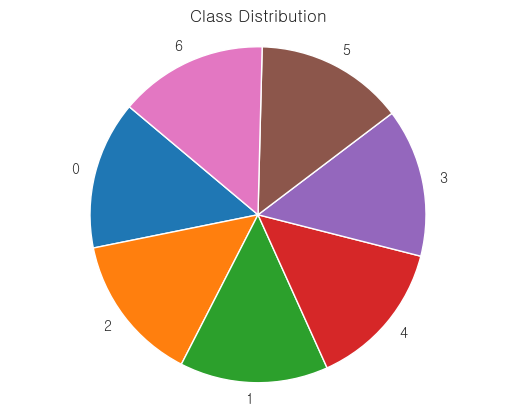

In [60]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

class_counts = y_res.value_counts()

plt.pie(class_counts, labels=class_counts.index, startangle=140)
plt.axis('equal')
plt.title('Class Distribution')
plt.show()

In [20]:
params = {
    'n_estimators': 100,
    'criterion': 'entropy',
    'max_depth': 80,
    'min_samples_split': 2,
    'min_samples_leaf': 2,
    'class_weight': 'balanced',
}

rf_model = RandomForestClassifier(**params)
rf_model.fit(X_train, y_train)
print("Random Forest Accuracy:", accuracy_score(y_test, rf_model.predict(X_test)))

feature_importances = pd.DataFrame(rf_model.feature_importances_, index=X.columns, columns=['Importance']).sort_values(
    'Importance', ascending=False)
print(feature_importances)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=80, min_samples_leaf=2)

Random Forest Accuracy: 0.8053896879381068
              Importance
총상환이자           0.277185
총상환원금           0.244421
대출금액            0.095291
연간소득            0.077860
대출기간            0.076517
부채_대비_소득_비율     0.074630
총계좌수            0.059546
근로기간            0.035935
대출목적            0.029091
주택소유상태          0.016423
최근_2년간_연체_횟수    0.012805
연체계좌수           0.000297
총연체금액           0.000000


In [21]:
category_list = ['대출기간', '근로기간', '주택소유상태', '대출목적']

for i in range(len(category_list)):
    contingency_table = pd.crosstab(train['대출등급'], train[category_list[i]])
    chi, p, dof, _ = chi2_contingency(contingency_table)
    print(f'{category_list[i]}: p_value = {p:.2f}, chi = {chi:.3f}, Degree Of Freedom = {dof}')

대출기간: p_value = 0.00, chi = 19134.184, Degree Of Freedom = 6
근로기간: p_value = 0.00, chi = 145.508, Degree Of Freedom = 60
주택소유상태: p_value = 0.00, chi = 663.433, Degree Of Freedom = 18
대출목적: p_value = 0.00, chi = 5744.213, Degree Of Freedom = 66


In [22]:
X = train[to_normalize_list]
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

       Variable       VIF
0          대출금액  8.401844
1          연간소득  4.649995
2   부채_대비_소득_비율  4.427026
3          총계좌수  6.105392
4  최근_2년간_연체_횟수  1.191162
5         총상환원금  3.126879
6         총상환이자  3.722976
7         총연체금액       NaN
8         연체계좌수  1.025250


<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Pearson Correlation Heatmap')

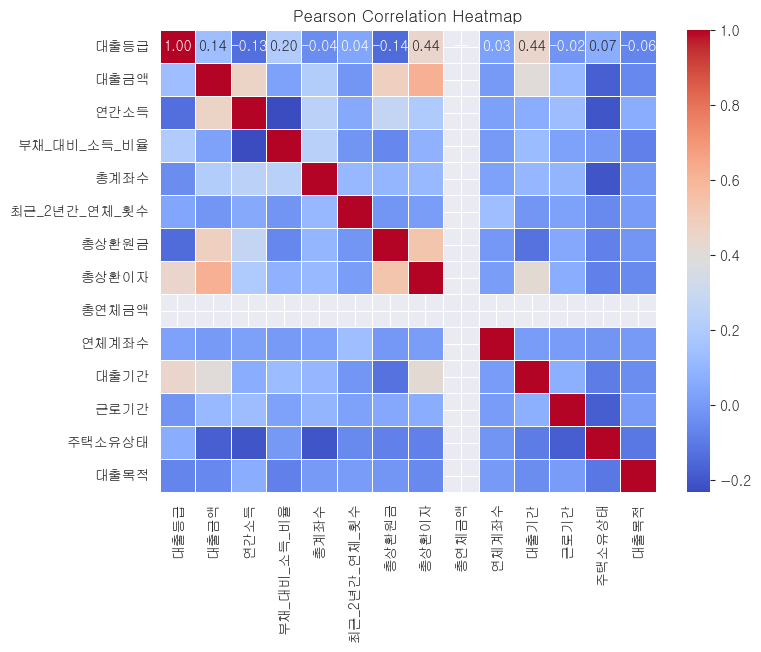

<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Spearman Correlation Heatmap')

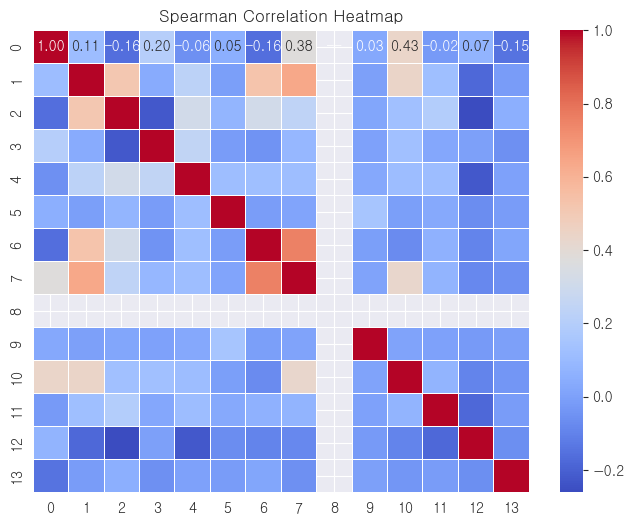

In [23]:
correlation_matrix = train.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Pearson Correlation Heatmap')
plt.show()

correlation_matrix, _ = spearmanr(train)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Spearman Correlation Heatmap')
plt.show()

In [562]:
train.drop(columns=['최근_2년간_연체_횟수', '총연체금액', '연체계좌수'], inplace=True)
test.drop(columns=['최근_2년간_연체_횟수', '총연체금액', '연체계좌수'], inplace=True)

In [563]:
train.to_csv('../Database/train_for_DNN.csv')
test.to_csv('../Database/test_for_DNN.csv')